In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('consumer_durable.csv', index_col=['date'])
prices.head(10)

TITAN.NS  HAVELLS.NS   VOLTAS.NS  CROMPTON.NS  BATAINDIA.NS  \
date                                                                        
01-01-2018  852.450012  554.450012  648.950012   270.600006    755.299988   
02-01-2018  845.150024  549.250000  647.400024   277.799988    753.900024   
03-01-2018  856.299988  555.650024  643.599976   280.149994    772.400024   
04-01-2018  892.900024  562.849976  645.700012   282.950012    767.349976   
05-01-2018  909.700012  566.049988  646.349976   279.000000    764.799988   
08-01-2018  926.099976  563.099976  638.650024   273.950012    761.549988   
09-01-2018  932.950012  552.250000  648.599976   276.100006    746.900024   
10-01-2018  917.599976  549.700012  629.299988   270.500000    753.950012   
11-01-2018  906.900024  548.799988  625.849976   272.649994    749.700012   
12-01-2018  903.799988  549.099976  633.950012   272.250000    746.099976   

            KAJARIACER.NS  RAJESHEXPO.NS   RELAXO.NS  BLUESTARCO.NS  
date                                                                 
01-01-2018     725.099976     804.700012  343.424988     821.500000  
02-01-2018     712.950012     816.250000  335.450012     817.799988  
03-01-2018     736.950012     809.750000  343.000000     818.200012  
04-01-2018     743.700012     847.750000  340.200012     815.000000  
05-01-2018     750.849976     820.549988  339.774994     819.750000  
08-01-2018     748.150024     820.349976  336.875000     816.500000  
09-01-2018     753.000000     827.450012  337.274994     804.349976  
10-01-2018     747.599976     827.150024  339.950012     806.500000  
11-01-2018     742.000000     818.299988  337.600006     800.799988  
12-01-2018     739.549988     818.250000  339.024994     789.400024

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

TITAN.NS  HAVELLS.NS   VOLTAS.NS  CROMPTON.NS  BATAINDIA.NS  \
date                                                                         
01-01-2018   852.450012  554.450012  648.950012   270.600006    755.299988   
02-01-2018   845.150024  549.250000  647.400024   277.799988    753.900024   
30-12-2020  1552.599976  904.650024  819.799988   368.350006   1581.099976   
31-12-2020  1567.150024  916.150024  825.650024   380.549988   1579.650024   

            KAJARIACER.NS  RAJESHEXPO.NS   RELAXO.NS  BLUESTARCO.NS  
date                                                                 
01-01-2018     725.099976     804.700012  343.424988     821.500000  
02-01-2018     712.950012     816.250000  335.450012     817.799988  
30-12-2020     689.650024     486.799988  801.299988     801.549988  
31-12-2020     703.599976     490.549988  809.700012     801.099976

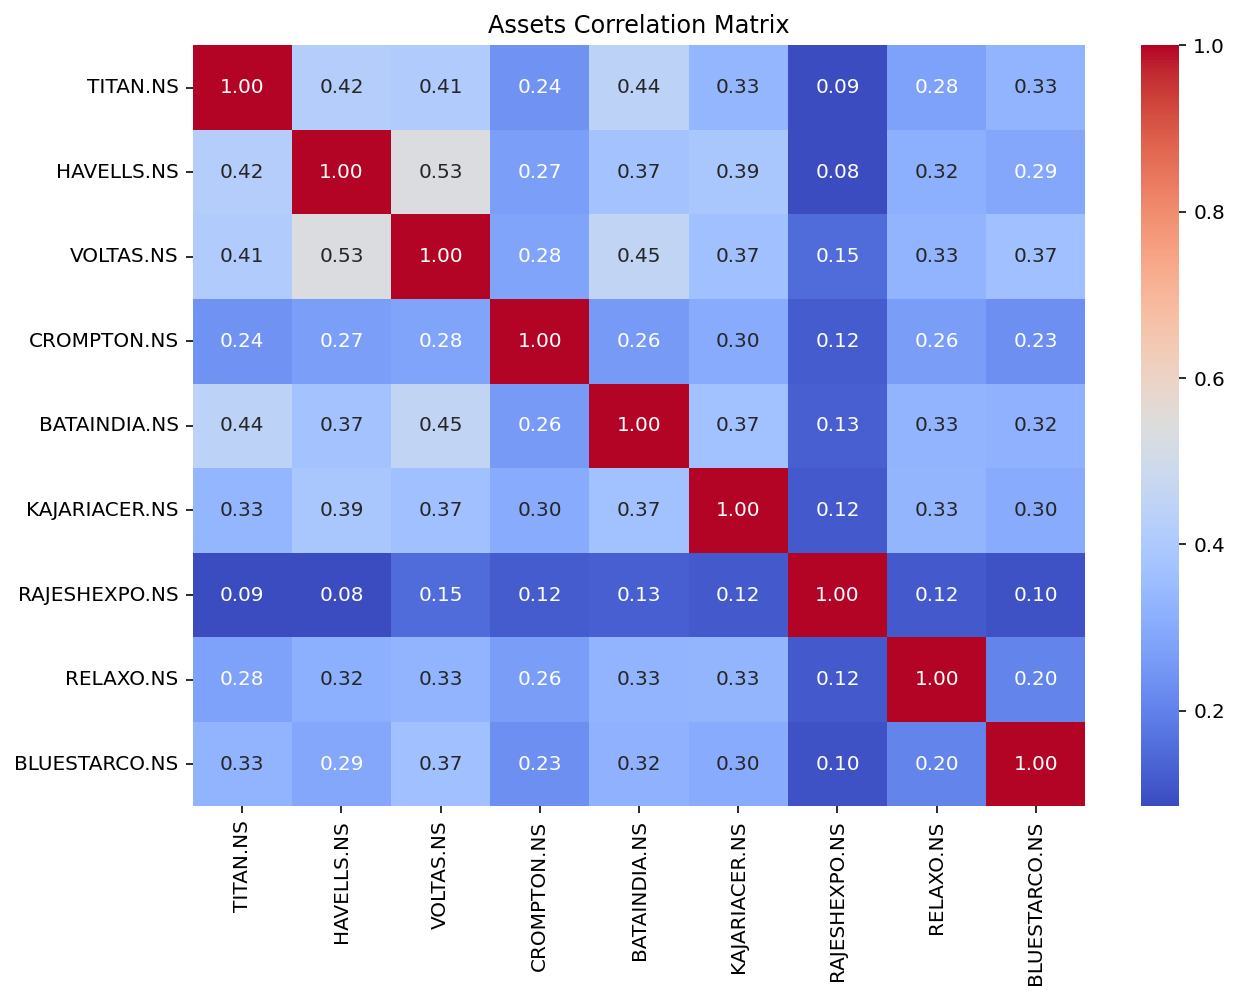

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('VOLTAS.NS', 'CROMPTON.NS')]


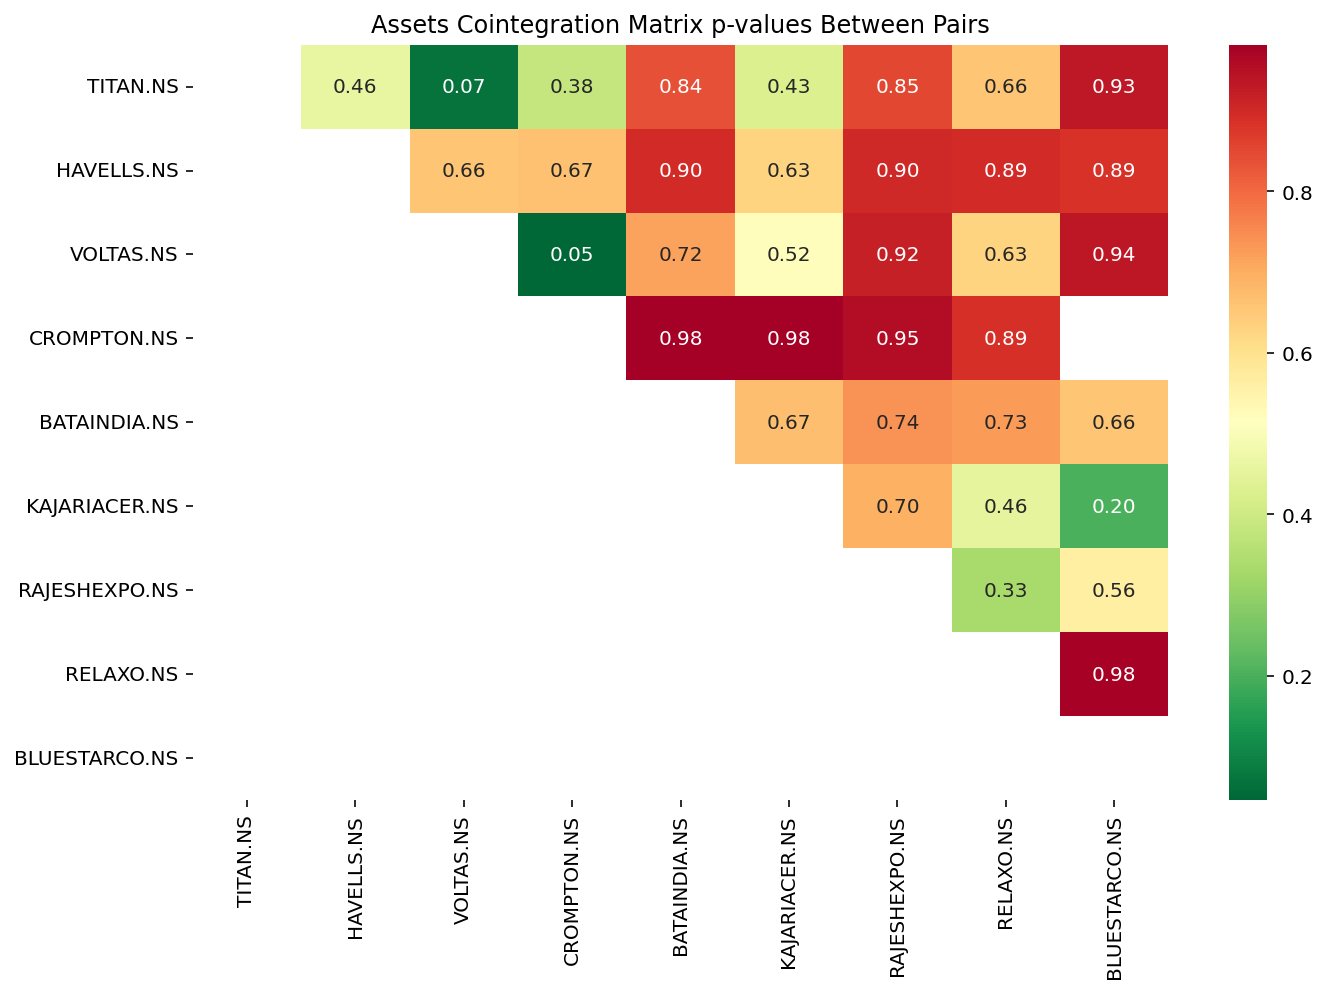

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'TITAN.NS'
asset2 = 'CROMPTON.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

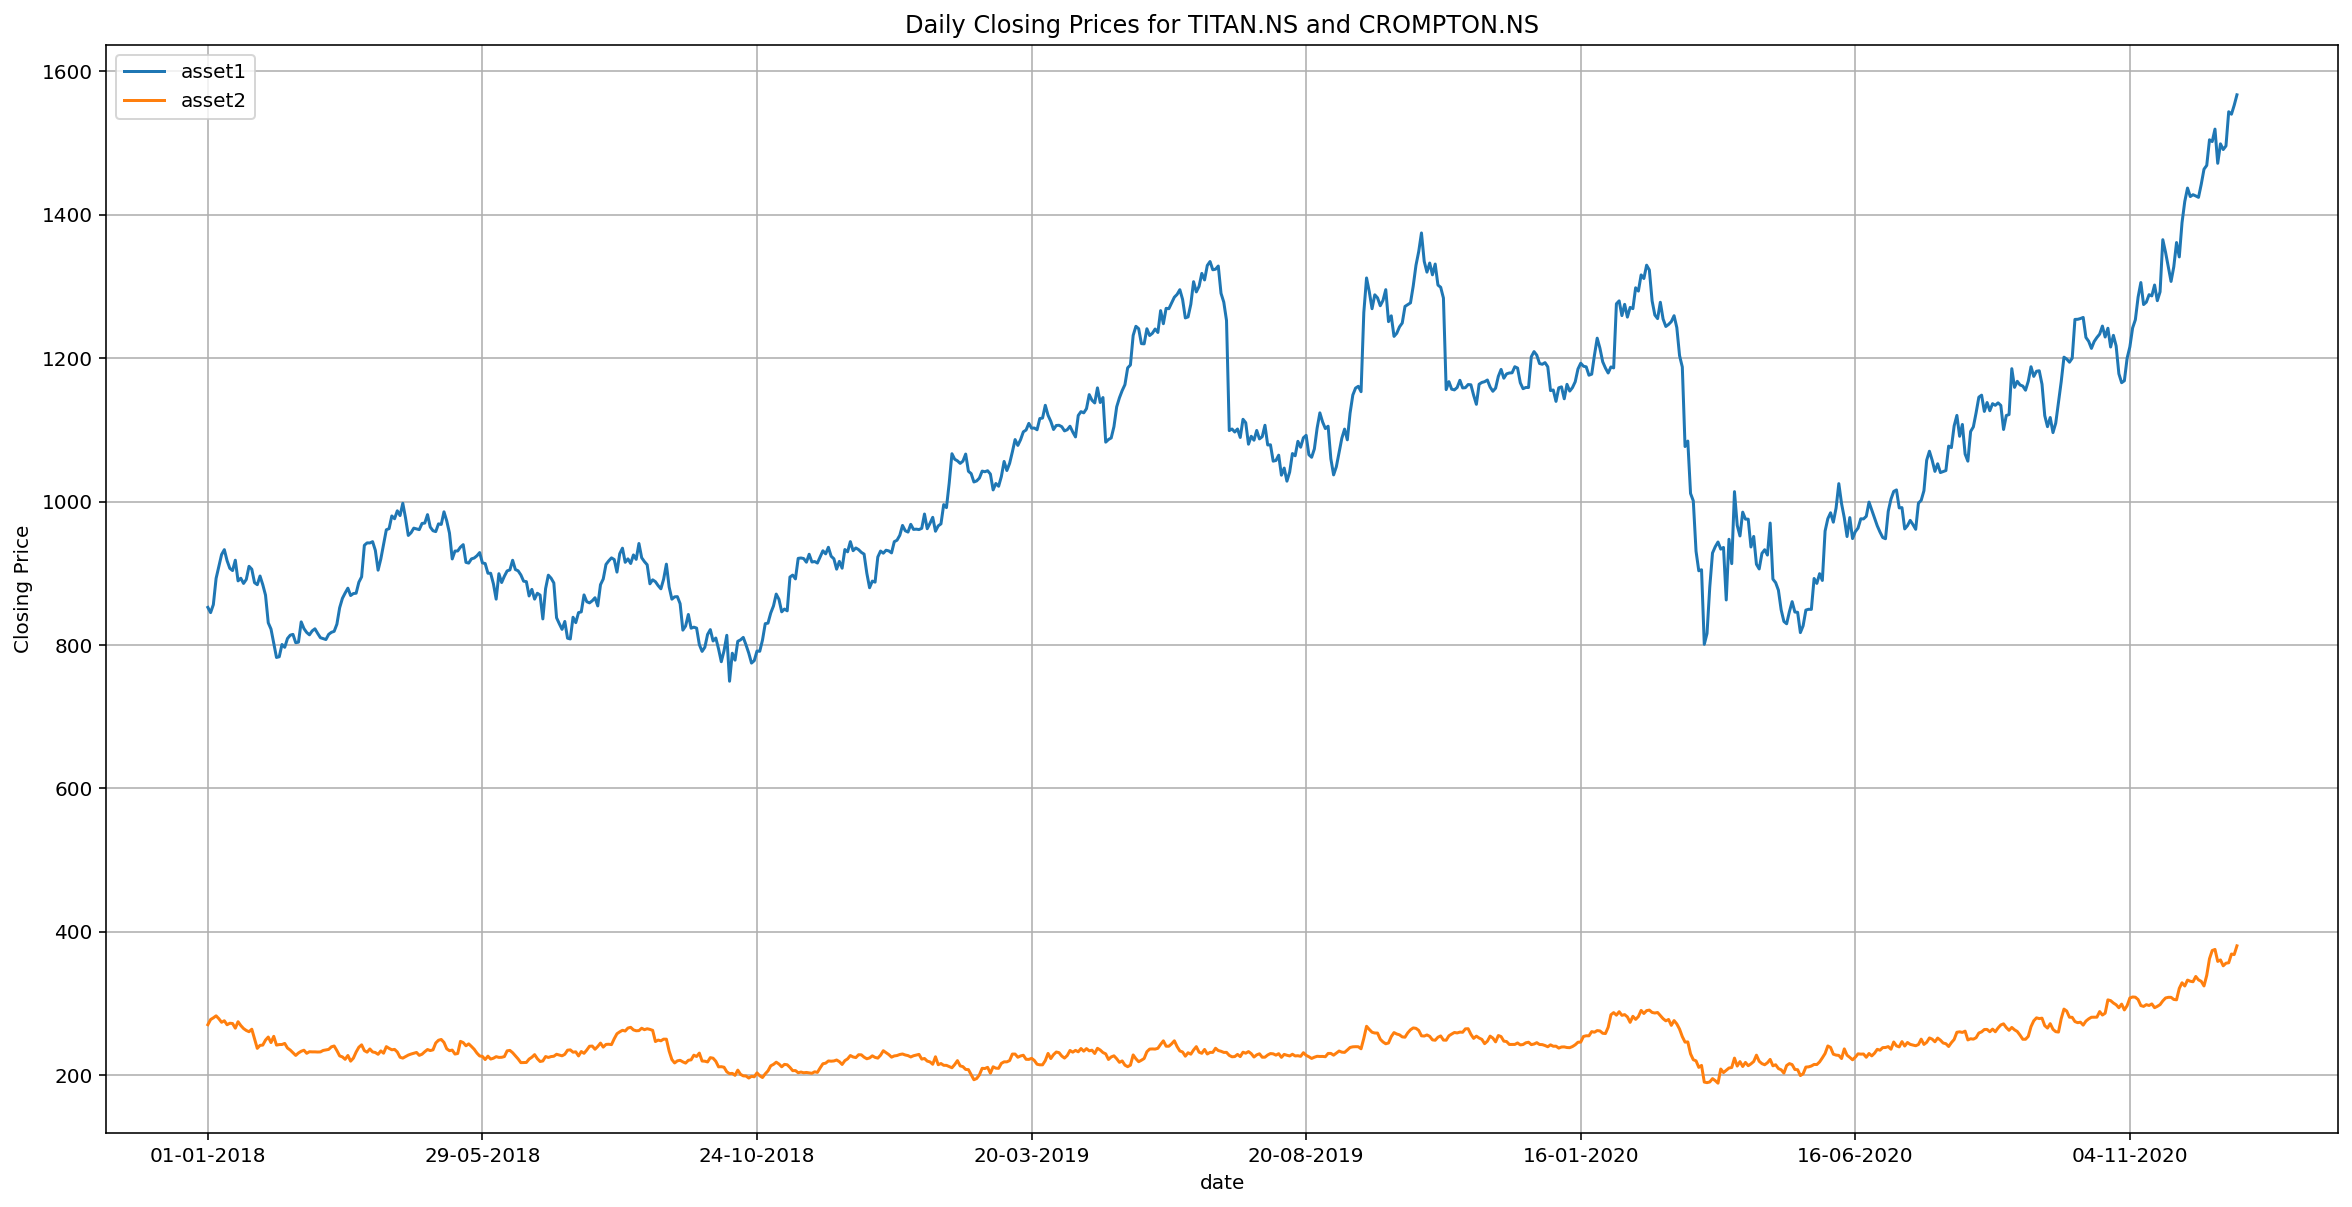

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                          5.139e+04
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                        0.00
Time:                        08:20:38   Log-Likelihood:                         -3544.5
No. Observations:                 740   AIC:                                      7091.
Df Residuals:                     739   BIC:                                      7096.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.2280      0.001    226.688      0.000       0.226       0.230
==============================================================================
Omnibus:                        0.428   Durbin-Watson:                   0.046
Prob(Omnibus):                  0.807   Jarque-Bera (JB):                0.528
Skew:                          -0.023   Prob(JB):                        0.768
Kurtosis:                       2.877   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

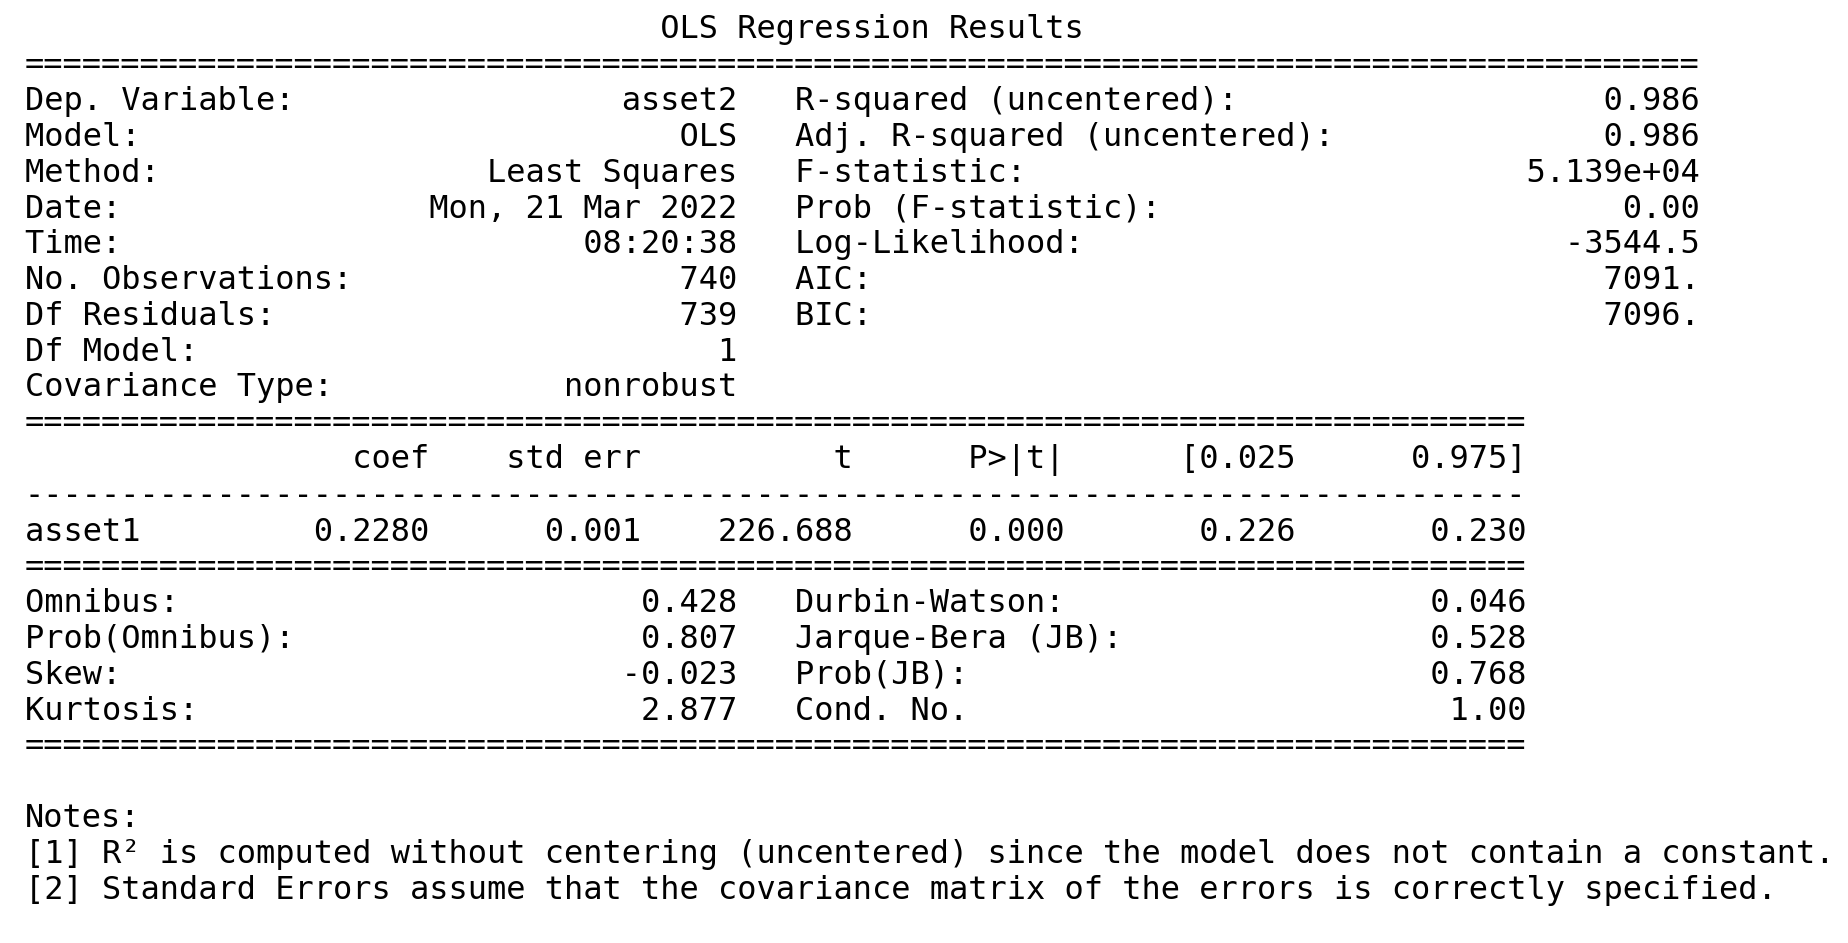

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.2279542485925486


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

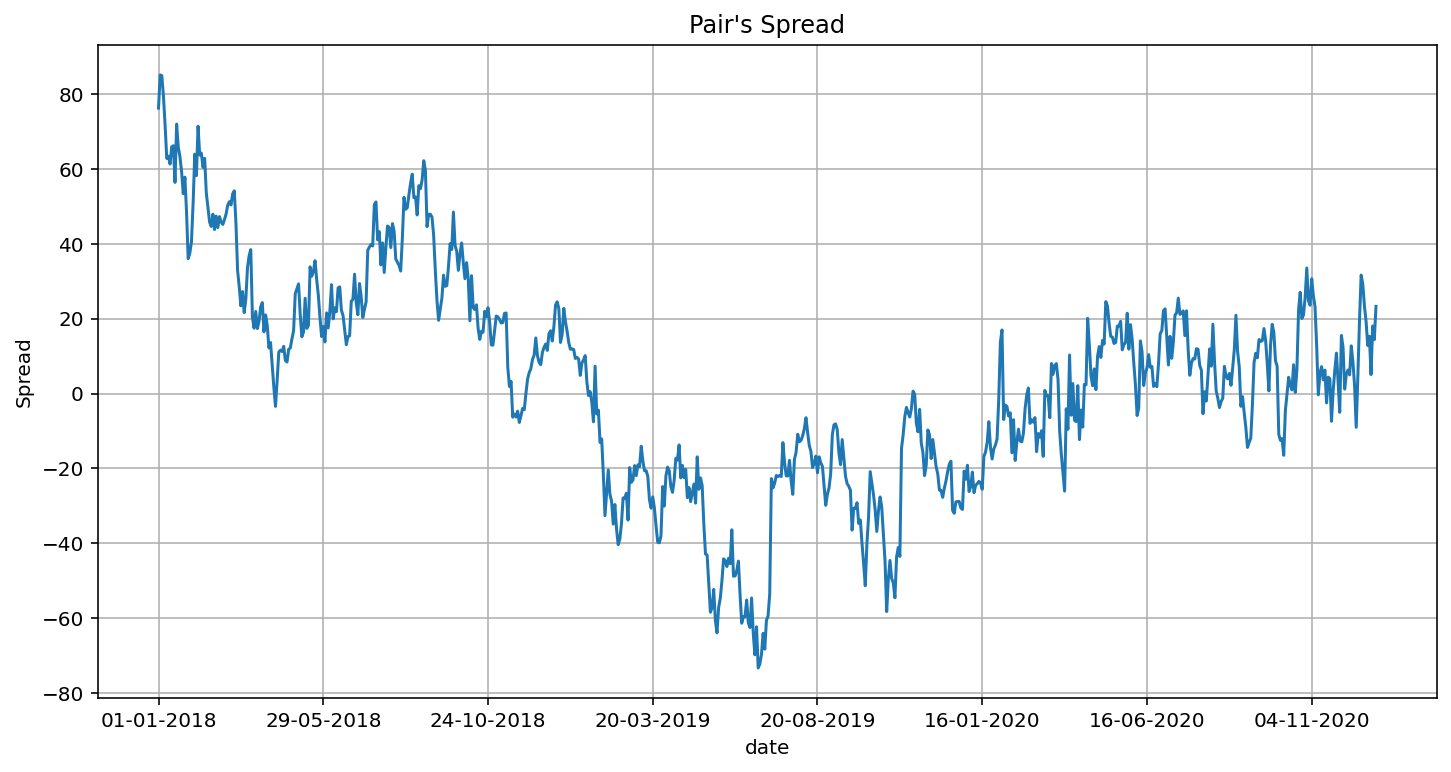

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-3.394456369045302,
 0.011149311559667668,
 1,
 738,
 {'1%': -3.4392418578608983,
  '5%': -2.86546426916434,
  '10%': -2.568859710342903},
 4785.4975469581295)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -3.394456369045302


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.4392418578608983, '5%': -2.86546426916434, '10%': -2.568859710342903}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1      asset2
date                               
01-01-2021  1558.599976  378.049988
04-01-2021  1550.900024  373.700012
05-01-2021  1570.949951  377.350006
06-01-2021  1572.599976  383.899994
07-01-2021  1542.349976  395.049988

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                       
01-01-2021  1558.599976  378.049988 -0.237465            1.0           -1.0
04-01-2021  1550.900024  373.700012 -0.195172            1.0           -1.0
05-01-2021  1570.949951  377.350006 -0.175109            1.0           -1.0
06-01-2021  1572.599976  383.899994 -0.278169            1.0           -1.0
07-01-2021  1542.349976  395.049988 -0.574985            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

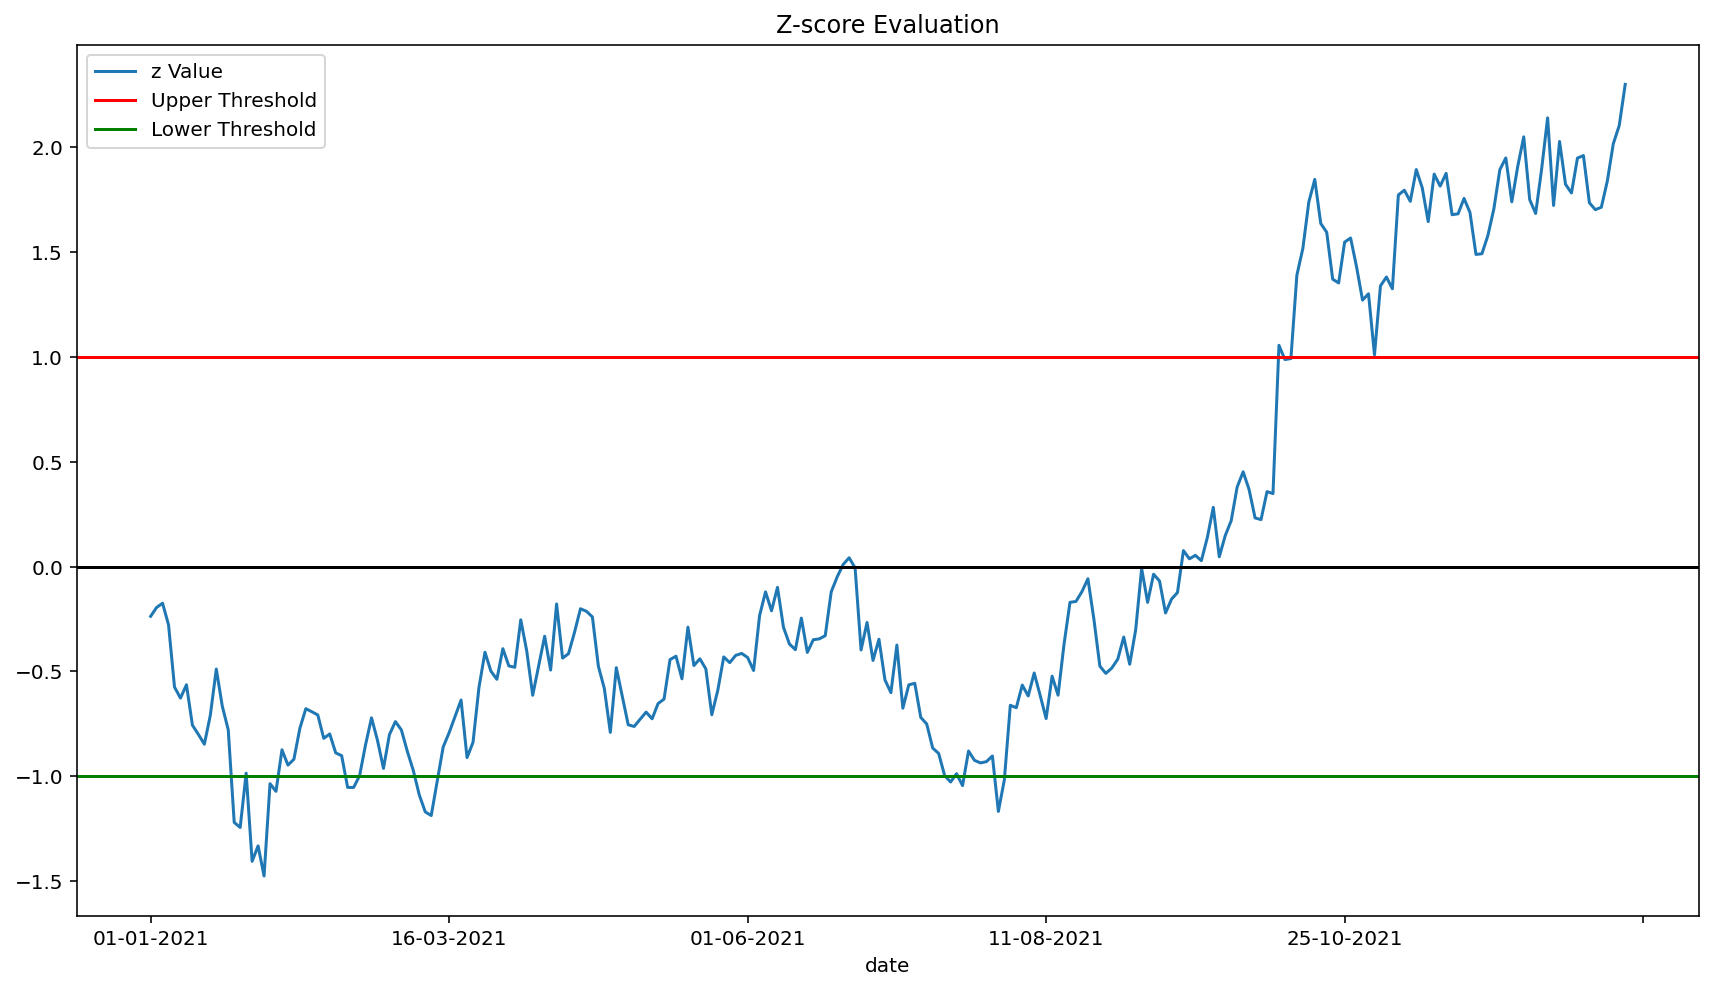

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  1558.599976  378.049988 -0.237465            1.0           -1.0   
04-01-2021  1550.900024  373.700012 -0.195172            1.0           -1.0   
05-01-2021  1570.949951  377.350006 -0.175109            1.0           -1.0   
29-12-2021  2402.149902  430.299988  2.016984            1.0           -1.0   
30-12-2021  2437.300049  432.200012  2.104685            1.0           -1.0   
31-12-2021  2522.399902  437.450012  2.300602            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
29-12-2021        -1         0.0         1         0.0  
30-12-2021        -1         0.0         1         0.0  
31-12-2021        -1         0.0         1         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
21-01-2021  1517.300049  435.250000 -1.220767            1.0           -1.0   
22-01-2021  1491.199951  429.700012 -1.245037            1.0           -1.0   
27-01-2021  1440.699951  428.049988 -1.406580            1.0           -1.0   
28-01-2021  1450.099976  424.799988 -1.332637            1.0           -1.0   
29-01-2021  1420.300049  427.750000 -1.476588            1.0           -1.0   
01-02-2021  1501.550049  416.450012 -1.036132            1.0           -1.0   
02-02-2021  1485.449951  414.700012 -1.072592            1.0           -1.0   
18-02-2021  1433.000000  398.700012 -1.053760            1.0           -1.0   
19-02-2021  1425.550049  396.649994 -1.054078            1.0           -1.0   
08-03-2021  1456.750000  407.950012 -1.089710            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
21-01-2021         1         1.0        -1        -1.0  
22-01-2021         1         0.0        -1         0.0  
27-01-2021         1         1.0        -1        -1.0  
28-01-2021         1         0.0        -1         0.0  
29-01-2021         1         0.0        -1         0.0  
01-02-2021         1         0.0        -1         0.0  
02-02-2021         1         0.0        -1         0.0  
18-02-2021         1         1.0        -1        -1.0  
19-02-2021         1         0.0        -1         0.0  
08-03-2021         1         1.0        -1        -1.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  1558.599976  378.049988 -0.237465            1.0           -1.0   
21-01-2021  1517.300049  435.250000 -1.220767            1.0           -1.0   
25-01-2021  1499.849976  412.250000 -0.985769            1.0           -1.0   
27-01-2021  1440.699951  428.049988 -1.406580            1.0           -1.0   
03-02-2021  1525.150024  411.049988 -0.874309            1.0           -1.0   
30-07-2021  1714.550049  487.100006 -1.168457            1.0           -1.0   
03-08-2021  1840.199951  478.250000 -0.662106            1.0           -1.0   
07-10-2021  2375.350098  478.899994  1.055619            1.0           -1.0   
08-10-2021  2358.199951  479.700012  0.987629            1.0           -1.0   
12-10-2021  2492.600098  481.500000  1.390330            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
21-01-2021         1         1.0        -1        -1.0  
25-01-2021         0        -1.0         0         1.0  
27-01-2021         1         1.0        -1        -1.0  
03-02-2021         0        -1.0         0         1.0  
30-07-2021         1         1.0        -1        -1.0  
03-08-2021         0        -1.0         0         1.0  
07-10-2021        -1        -1.0         1         1.0  
08-10-2021         0         1.0         0        -1.0  
12-10-2021        -1        -1.0         1         1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

1517.300049    1
1440.699951    1
1433.000000    1
1456.750000    1
1680.349976    1
1701.750000    1
1714.550049    1
2358.199951    1
Name: asset1, dtype: int64

In [32]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  1558.599976  378.049988 -0.237465            1.0           -1.0   
04-01-2021  1550.900024  373.700012 -0.195172            1.0           -1.0   
05-01-2021  1570.949951  377.350006 -0.175109            1.0           -1.0   
06-01-2021  1572.599976  383.899994 -0.278169            1.0           -1.0   
07-01-2021  1542.349976  395.049988 -0.574985            1.0           -1.0   
...                 ...         ...       ...            ...            ...   
27-12-2021  2331.300049  432.799988  1.714364            1.0           -1.0   
28-12-2021  2379.850098  435.299988  1.838837            1.0           -1.0   
29-12-2021  2402.149902  430.299988  2.016984            1.0           -1.0   
30-12-2021  2437.300049  432.200012  2.104685            1.0           -1.0   
31-12-2021  2522.399902  437.450012  2.300602            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
06-01-2021         0         0.0         0         0.0  
07-01-2021         0         0.0         0         0.0  
...              ...         ...       ...         ...  
27-12-2021        -1         0.0         1         0.0  
28-12-2021        -1         0.0         1         0.0  
29-12-2021        -1         0.0         1         0.0  
30-12-2021        -1         0.0         1         0.0  
31-12-2021        -1         0.0         1         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    1558.599976           NaN            NaN            NaN       NaN   
1    1550.900024      0.000000  100000.000000  100000.000000       NaN   
2    1570.949951      0.000000  100000.000000  100000.000000  0.000000   
3    1572.599976      0.000000  100000.000000  100000.000000  0.000000   
4    1542.349976      0.000000  100000.000000  100000.000000  0.000000   
243  2331.300049 -88589.401862  202613.303686  114023.901824 -0.003934   
244  2379.850098 -90434.303724  202613.303686  112178.999962 -0.016180   
245  2402.149902 -91281.696276  202613.303686  111331.607410 -0.007554   
246  2437.300049 -92617.401862  202613.303686  109995.901824 -0.011998   
247  2522.399902 -95851.196276  202613.303686  106762.107410 -0.029399   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   1558.599976           NaN            NaN            NaN       NaN   
14  1517.300049  57657.401862   42342.598138  100000.000000  0.000000   
16  1499.849976      0.000000   99336.897226   99336.897226  0.003320   
17  1440.699951  54746.598138   44590.299088   99336.897226  0.000000   
22  1525.150024      0.000000  102546.000000  102546.000000  0.014931   

    positions1  
0          NaN  
14         1.0  
16        -1.0  
17         1.0  
22        -1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    1558.599976           NaN            NaN            NaN       NaN   
1    1550.900024      0.000000  100000.000000  100000.000000       NaN   
2    1570.949951      0.000000  100000.000000  100000.000000  0.000000   
3    1572.599976      0.000000  100000.000000  100000.000000  0.000000   
4    1542.349976      0.000000  100000.000000  100000.000000  0.000000   
243  2331.300049 -88589.401862  202613.303686  114023.901824 -0.003934   
244  2379.850098 -90434.303724  202613.303686  112178.999962 -0.016180   
245  2402.149902 -91281.696276  202613.303686  111331.607410 -0.007554   
246  2437.300049 -92617.401862  202613.303686  109995.901824 -0.011998   
247  2522.399902 -95851.196276  202613.303686  106762.107410 -0.029399   

     positions1      asset2     holdings2          cash2   total asset2  \
0           NaN  378.049988           NaN            NaN            NaN   
1           0.0  373.700012      0.000000  100000.000000  100000.000000   
2           0.0  377.350006      0.000000  100000.000000  100000.000000   
3           0.0  383.899994      0.000000  100000.000000  100000.000000   
4           0.0  395.049988      0.000000  100000.000000  100000.000000   
243         0.0  432.799988  87858.397523   20028.159906  107886.557430   
244         0.0  435.299988  88365.897523   20028.159906  108394.057430   
245         0.0  430.299988  87350.897523   20028.159906  107379.057430   
246         0.0  432.200012  87736.602477   20028.159906  107764.762383   
247         0.0  437.450012  88802.352477   20028.159906  108830.512383   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243  0.003020         0.0  
244  0.004704         0.0  
245 -0.009364         0.0  
246  0.003592         0.0  
247  0.009890         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   1558.599976           NaN            NaN            NaN       NaN   
14  1517.300049  57657.401862   42342.598138  100000.000000  0.000000   
16  1499.849976      0.000000   99336.897226   99336.897226  0.003320   
17  1440.699951  54746.598138   44590.299088   99336.897226  0.000000   
22  1525.150024      0.000000  102546.000000  102546.000000  0.014931   

    positions1      asset2     holdings2          cash2  total asset2  \
0          NaN  378.049988           NaN            NaN           NaN   
14         1.0  435.250000 -88355.750000  188355.750000      100000.0   
16        -1.0  412.250000      0.000000  104669.000000      104669.0   
17         1.0  428.049988 -86894.147523  191563.147523      104669.0   
22        -1.0  411.049988      0.000000  108120.000000      108120.0   

     return2  positions2  
0        NaN         NaN  
14  0.000000        -1.0  
16  0.035029         1.0  
17  0.000000        -1.0  
22  0.006900         1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

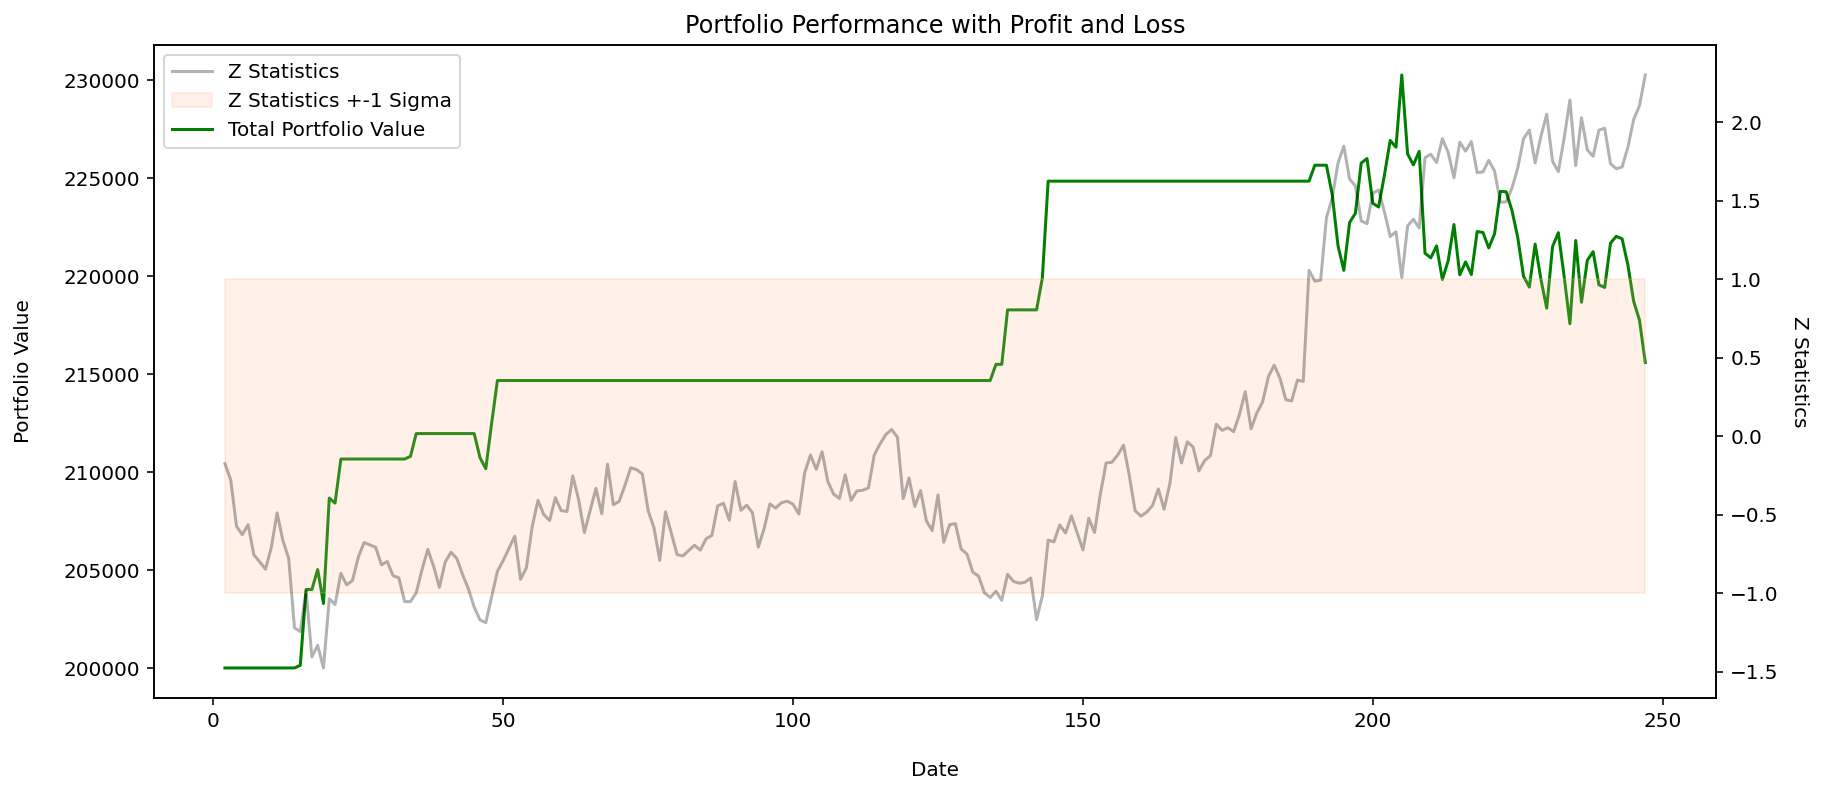

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [46]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

215592.619793

In [47]:
profit = final_portfolio - 2*initial_capital
profit

15592.61979299999

In [48]:
roi = (profit/(2*initial_capital))*100
roi

7.796309896499995

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [45]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 214.084%
